# Project: Chord recognition of Atonal music

In [1]:
!pip install libfmp

     |████████████████████████████████| 109 kB 5.1 MB/s 
     |████████████████████████████████| 790 kB 40.3 MB/s 
     |████████████████████████████████| 5.6 MB 20.6 MB/s 
     |████████████████████████████████| 18.5 MB 172 kB/s 
     |████████████████████████████████| 374 kB 54.5 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 
  Created wheel for music21: filename=music21-5.7.2-py3-none-any.whl size=22024624 sha256=849fb851eb579735a00383dc51f0726bb0d1352adad3726952ca3c85f06ae5b6
  Stored in directory: /root/.cache/pip/wheels/bc/cb/ae/fd264ebf1e9cf01c15576ee4c128f1bfd907a120c0a7a5b542
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591953 sha256=d4314fe7917c42a668ef1e01a935b329b3be23c39b61adf56716c613bd1f1ae9
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built music21 pretty-midi
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolki

In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import libfmp.b
import libfmp.c3
import libfmp.c4
import libfmp.c5

Sources:

https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S2_ChordRec_Templates.html

https://www.audiolabs-erlangen.de/resources/MIR/FMP/C5/C5S3_ChordRec_HMM.html


# 1. Template based chord recognition


In [3]:
def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None):

    x, Fs = librosa.load(fn_wav, sr=Fs, duration=10)
    x_dur = x.shape[0] / Fs
    X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
    if gamma is not None:
        X = np.log(1 + gamma * np.abs(X) ** 2)
    else:
        X = np.abs(X) ** 2
    X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    X = libfmp.c3.normalize_feature_sequence(X, norm='2')
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur

def plot_chromagram_annotation(ax, X, Fs_X, ann, color_ann, x_dur, cmap='gray_r', title=''):

    libfmp.b.plot_chromagram(X, Fs=Fs_X, ax=ax,
                             chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True)
    libfmp.b.plot_segments_overlay(ann, ax=ax[0], time_max=x_dur,
                                   print_labels=False, colors=color_ann, alpha=0.1)





In [4]:
def get_labels(m='m', nonchord=True):
    major = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    minor = [s + m for s in major]
    chord_labels = major + minor
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

def generate_templates(nonchord=True):
    cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    num_chord = 24
    if nonchord:
        num_chord = 25
    template = np.ones((12, num_chord))
    for shift in range(12):
        template[:, shift] = np.roll(cmaj, shift)
        template[:, shift+12] = np.roll(cmin, shift)
    return template

def chord_template(X, norm_sim='1', nonchord=True):

    template = generate_templates(nonchord=nonchord)
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(template, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_max_index, chord_max, chord_sim

def chord_prediction(chord_max_index, chord_labels, T):
  chords = []
  ann = [0, 0, 0]
  first = True
  t = -T*1.3
  for i in chord_max_index:
    if first:
      t += T
      ann = [0, t, chord_labels[i]]
      first = False
    if chord_labels[i] == ann[2]:
      t += T
      ann[1] = t
      
    
    else:    
      chords.append(ann)
      ann = [t, t+T, chord_labels[i]]
      t += T

  return chords
    



In [5]:
# Plot
def plot_final(x, Fs, X, chord_max, chords, chord_labels, Fs_X, X_chord):
  color_ann = {'C': [0, 0, 0, 0], 'C#': [0.5, 0, 0, 0], 'D': [1, 0, 0, 0], 'D#': [0, 0.5, 0, 0], 'E': [0, 1, 0, 0], 'F': [0, 0, 0.5, 0], 
              'F#': [0, 0, 1, 0], 'G': [0.5, 0.5, 0, 0.5], 'G#': [0, 0, 0.5, 1], 'A': [1, 0.5, 0, 0], 'A#': [1, 1, 0, 0], 'B': [1, 0, 0.5, 0], 
              'Cm': [1, 0, 1, 0], 'C#m': [1, 0.5, 0.5, 0.5], 'Dm': [1, 0, 0, 1], 'D#m': [1, 1, 0.5, 0], 'Em': [1, 0.5, 1, 0], 'Fm': [1, 1, 0, 0.5], 
              'F#m': [1, 1, 0.5, 1], 'Gm': [1, 0, 1, 0.5], 'G#m': [1, 0, 1, 1], 'Am': [0, 1, 0.5, 0], 'A#m': [0, 1, 1, 0], 'Bm': [0, 1, 1, 0.5], 'N': [1, 1, 1, 1]}
  cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
  fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                            'height_ratios': [1, 1.5, 3, 0.3]}, figsize=(32, 20))

  libfmp.b.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')
  libfmp.b.plot_segments_overlay(chords, ax=ax[0,0], time_max=x_dur,
                                print_labels=False, colors=color_ann, alpha=0.1)
  ax[0,1].axis('off')
  libfmp.b.plot_chromagram(X, ax=[ax[1,0], ax[1,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                          title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
  libfmp.b.plot_segments_overlay(chords, ax=ax[1,0], time_max=x_dur,
                                print_labels=False, colors=color_ann, alpha=0.1)

  """
  libfmp.b.plot_chromagram(X_chord, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='Binary templates of the chord recognition result')
  """
  libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                      title='Time–chord representation of chord recognition result',
                      ylabel='Chord', xlabel='')
  ax[2, 0].set_yticks(np.arange(len(chord_labels) ))
  ax[2, 0].set_yticklabels(chord_labels)
  ax[2, 0].grid()

  libfmp.b.plot_segments_overlay(chords, ax=ax[2, 0], time_max=x_dur,
                                print_labels=False, colors=color_ann, alpha=0.1)


  libfmp.b.plot_segments(chords, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                        colors=color_ann,  alpha=0.3)
  ax[3, 1].axis('off')
  plt.tight_layout()

def plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X):
  color_ann = {'C': [0, 0, 0, 0], 'C#': [0.5, 0, 0, 0], 'D': [1, 0, 0, 0], 'D#': [0, 0.5, 0, 0], 'E': [0, 1, 0, 0], 'F': [0, 0, 0.5, 0], 
              'F#': [0, 0, 1, 0], 'G': [0.5, 0.5, 0, 0.5], 'G#': [0, 0, 0.5, 1], 'A': [1, 0.5, 0, 0], 'A#': [1, 1, 0, 0], 'B': [1, 0, 0.5, 0], 
              'Cm': [1, 0, 1, 0], 'C#m': [1, 0.5, 0.5, 0.5], 'Dm': [1, 0, 0, 1], 'D#m': [1, 1, 0.5, 0], 'Em': [1, 0.5, 1, 0], 'Fm': [1, 1, 0, 0.5], 
              'F#m': [1, 1, 0.5, 1], 'Gm': [1, 0, 1, 0.5], 'G#m': [1, 0, 1, 1], 'Am': [0, 1, 0.5, 0], 'A#m': [0, 1, 1, 0], 'Bm': [0, 1, 1, 0.5], 'N': [1, 1, 1, 1]}
  cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
  fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                            'height_ratios': [1, 1.5, 3]}, figsize=(32, 20))

  libfmp.b.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')

  ax[0,1].axis('off')
  libfmp.b.plot_chromagram(X, ax=[ax[1,0], ax[1,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                          title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))



  libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                      title='Time–chord representation of chord recognition result',
                      ylabel='Chord', xlabel='')
  ax[2, 0].set_yticks(np.arange(len(chord_labels) ))
  ax[2, 0].set_yticklabels(chord_labels)
  ax[2, 0].grid()

  plt.tight_layout()

**Test with a beatles song to see if it works**

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


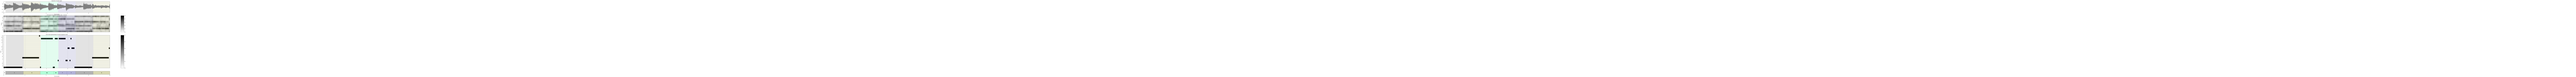

In [6]:
path = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/"
fn_wav =  path + "06. Let It Be.mp3"
#fn_wav =  path + "love me do.mp3"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
# Annotations
fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/06_-_Let_It_Be.csv"
#fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/love me do.csv"
ann, _ = libfmp.c4.read_structure_annotation(fn_ann)

chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

chord_templates = generate_templates(nonchord=False) 
X_chord = np.matmul(chord_templates, chord_max)


plot_final(x, Fs, X, chord_max, ann, chord_labels, Fs_X, X_chord)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


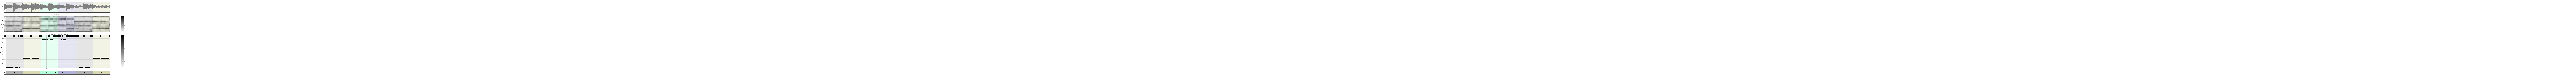

In [7]:
path = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/"
fn_wav =  path + "06. Let It Be.mp3"
#fn_wav =  path + "love me do.mp3"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
# Annotations
fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/06_-_Let_It_Be.csv"
#fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/love me do.csv"
ann, _ = libfmp.c4.read_structure_annotation(fn_ann)

chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

chord_templates = generate_templates(nonchord=True) 
X_chord = np.matmul(chord_templates, chord_max)


plot_final(x, Fs, X, chord_max, ann, chord_labels, Fs_X, X_chord)

# 2. HMM chord recognition


In [8]:
def uniform_transition_matrix(p=0.01, N=24):

    off_diag_entries = (1-p) / (N-1)     # rows should sum up to 1
    A = off_diag_entries * np.ones([N, N])
    np.fill_diagonal(A, p)
    return A

def viterbi_log_likelihood(A, C, B_O):
    I = A.shape[0]    # Number of states
    N = B_O.shape[1]  # Length of observation sequence
    tiny = np.finfo(0.).tiny
    A_log = np.log(A + tiny)
    C_log = np.log(C + tiny)
    B_O_log = np.log(B_O + tiny)

    # Initialize D and E matrices
    D_log = np.zeros((I, N))
    E = np.zeros((I, N-1)).astype(np.int32)
    D_log[:, 0] = C_log + B_O_log[:, 0]

    # Compute D and E in a nested loop
    for n in range(1, N):
        for i in range(I):
            temp_sum = A_log[:, i] + D_log[:, n-1]
            D_log[i, n] = np.max(temp_sum) + B_O_log[i, n]
            E[i, n-1] = np.argmax(temp_sum)

    # Backtracking
    S_opt = np.zeros(N).astype(np.int32)
    S_opt[-1] = np.argmax(D_log[:, -1])
    for n in range(N-2, -1, -1):
        S_opt[n] = E[int(S_opt[n+1]), n]

    # Matrix representation of result
    S_mat = np.zeros((I, N)).astype(np.int32)
    for n in range(N):
        S_mat[S_opt[n], n] = 1

    return S_mat, S_opt, D_log, E


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


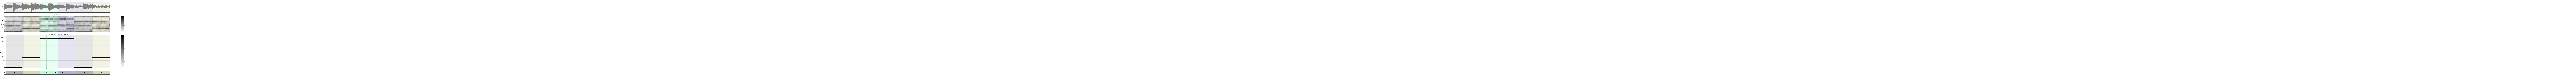

In [9]:
fn_wav =  path + "06. Let It Be.mp3"
#fn_wav =  path + "Help!.mp3"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
# Annotations
fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/06_-_Let_It_Be.csv"
#fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/Help!.csv"

ann, _ = libfmp.c4.read_structure_annotation(fn_ann)

chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)



A = uniform_transition_matrix(p=0.5)
C = 1 / 24 * np.ones((1, 24))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)


chord_templates = generate_templates(nonchord=False) 
X_chord = np.matmul(chord_templates, chord_HMM)


plot_final(x, Fs, X, chord_HMM, ann, chord_labels, Fs_X, X_chord)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


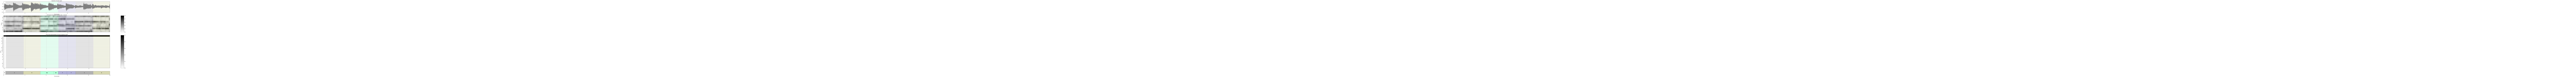

In [10]:
fn_wav =  path + "06. Let It Be.mp3"
#fn_wav =  path + "Help!.mp3"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Annotations
fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/06_-_Let_It_Be.csv"
#fn_ann = "/content/drive/MyDrive/DT2470 - Musikinformatik /Project/dataset/Help!.csv"

ann, _ = libfmp.c4.read_structure_annotation(fn_ann)

chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

chord_templates = generate_templates(nonchord=True) 
X_chord = np.matmul(chord_templates, chord_HMM)


plot_final(x, Fs, X, chord_HMM, ann, chord_labels, Fs_X, X_chord)

# 3. Multiple Tests


**Piano only**
1-05 6 Kleiner Klavierstücke, Op. 19 - 2. Langsam - Schoenberg

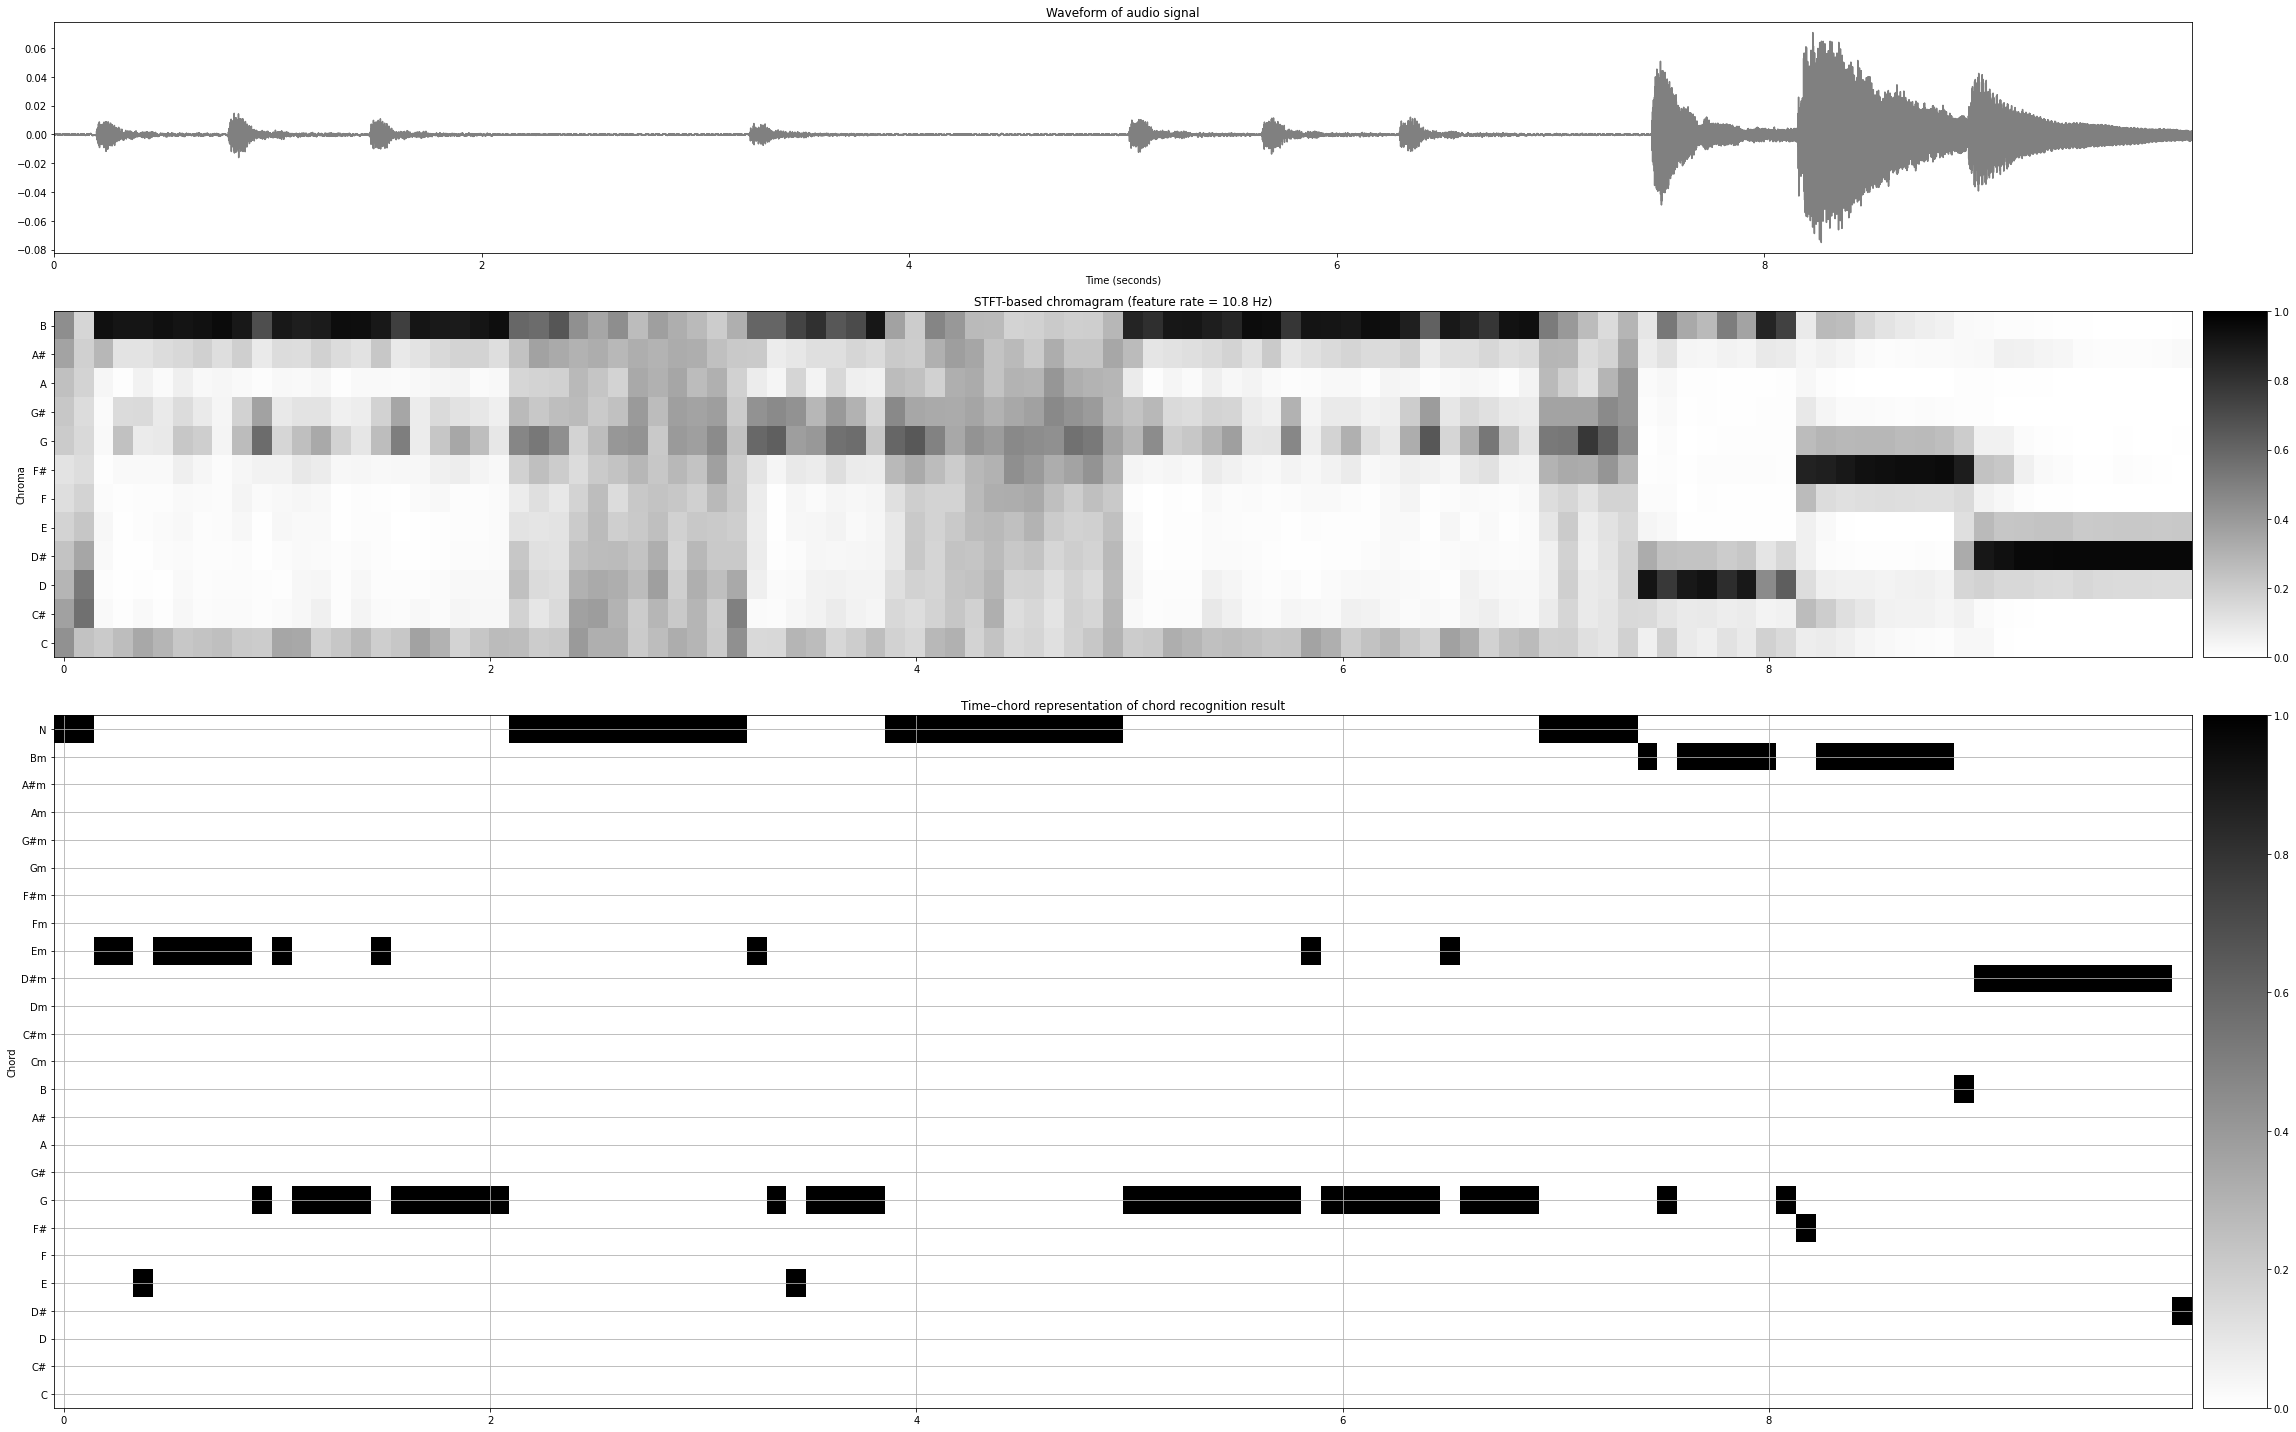

In [11]:
#Template, NonChord=True
fn_wav =  path + "1-05 6 Kleiner Klavierstücke, Op. 19 - 2. Langsam.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

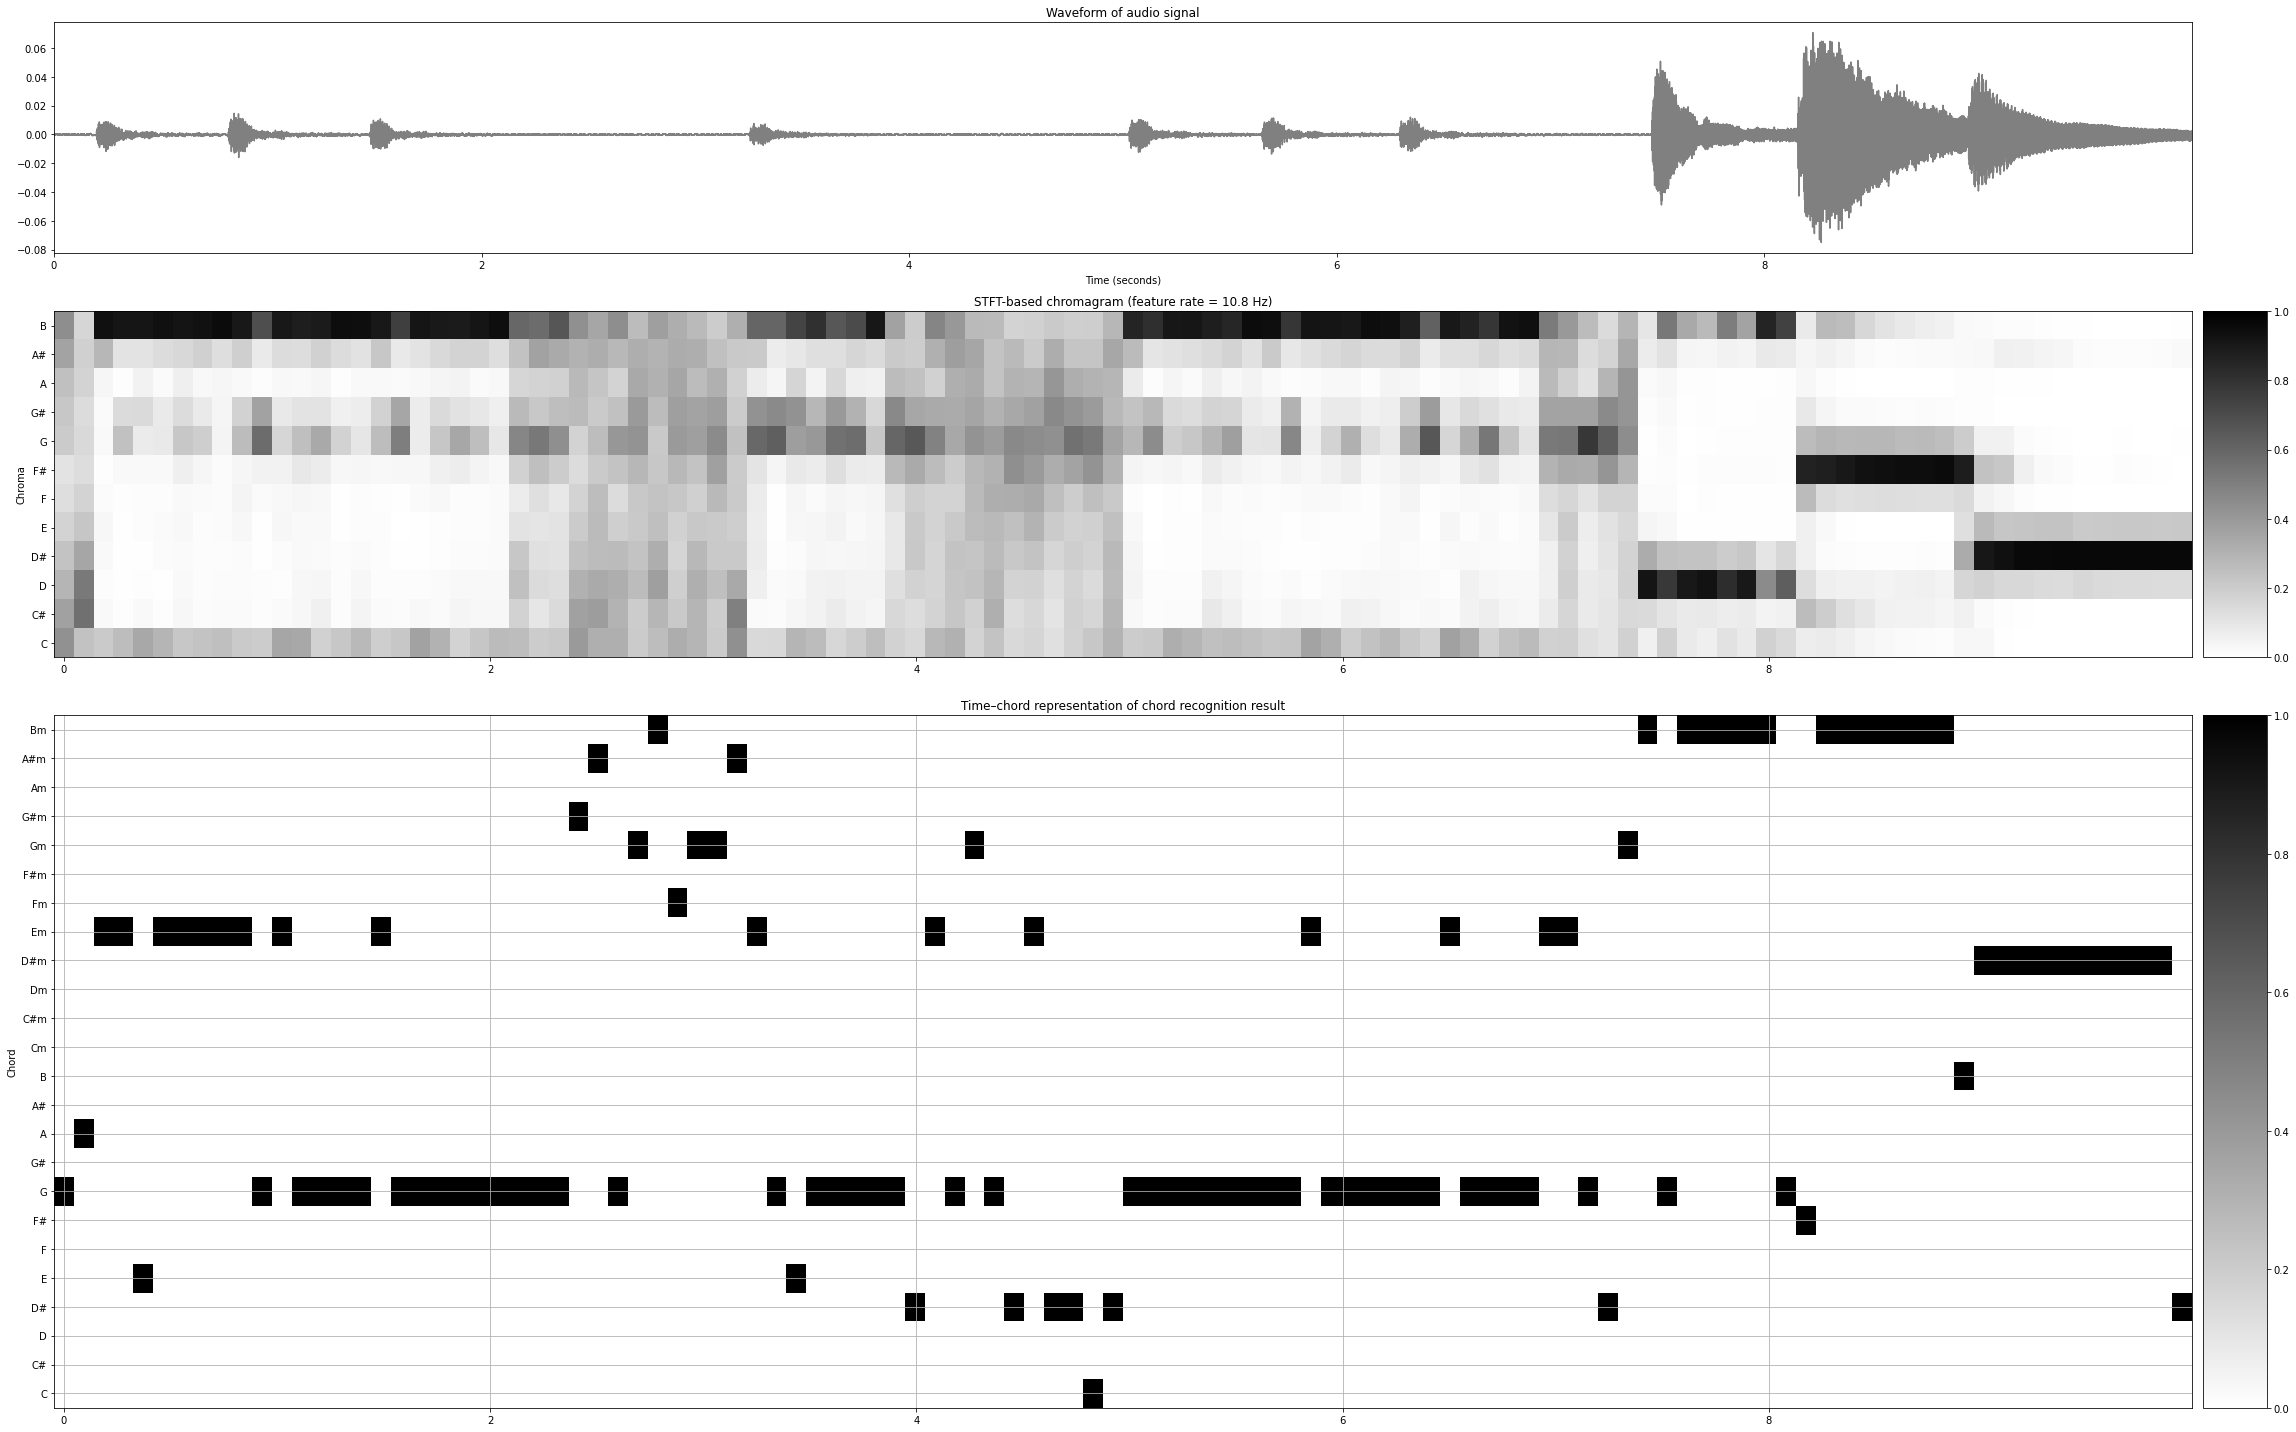

In [12]:
#Template, NonChord=False
fn_wav =  path + "1-05 6 Kleiner Klavierstücke, Op. 19 - 2. Langsam.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

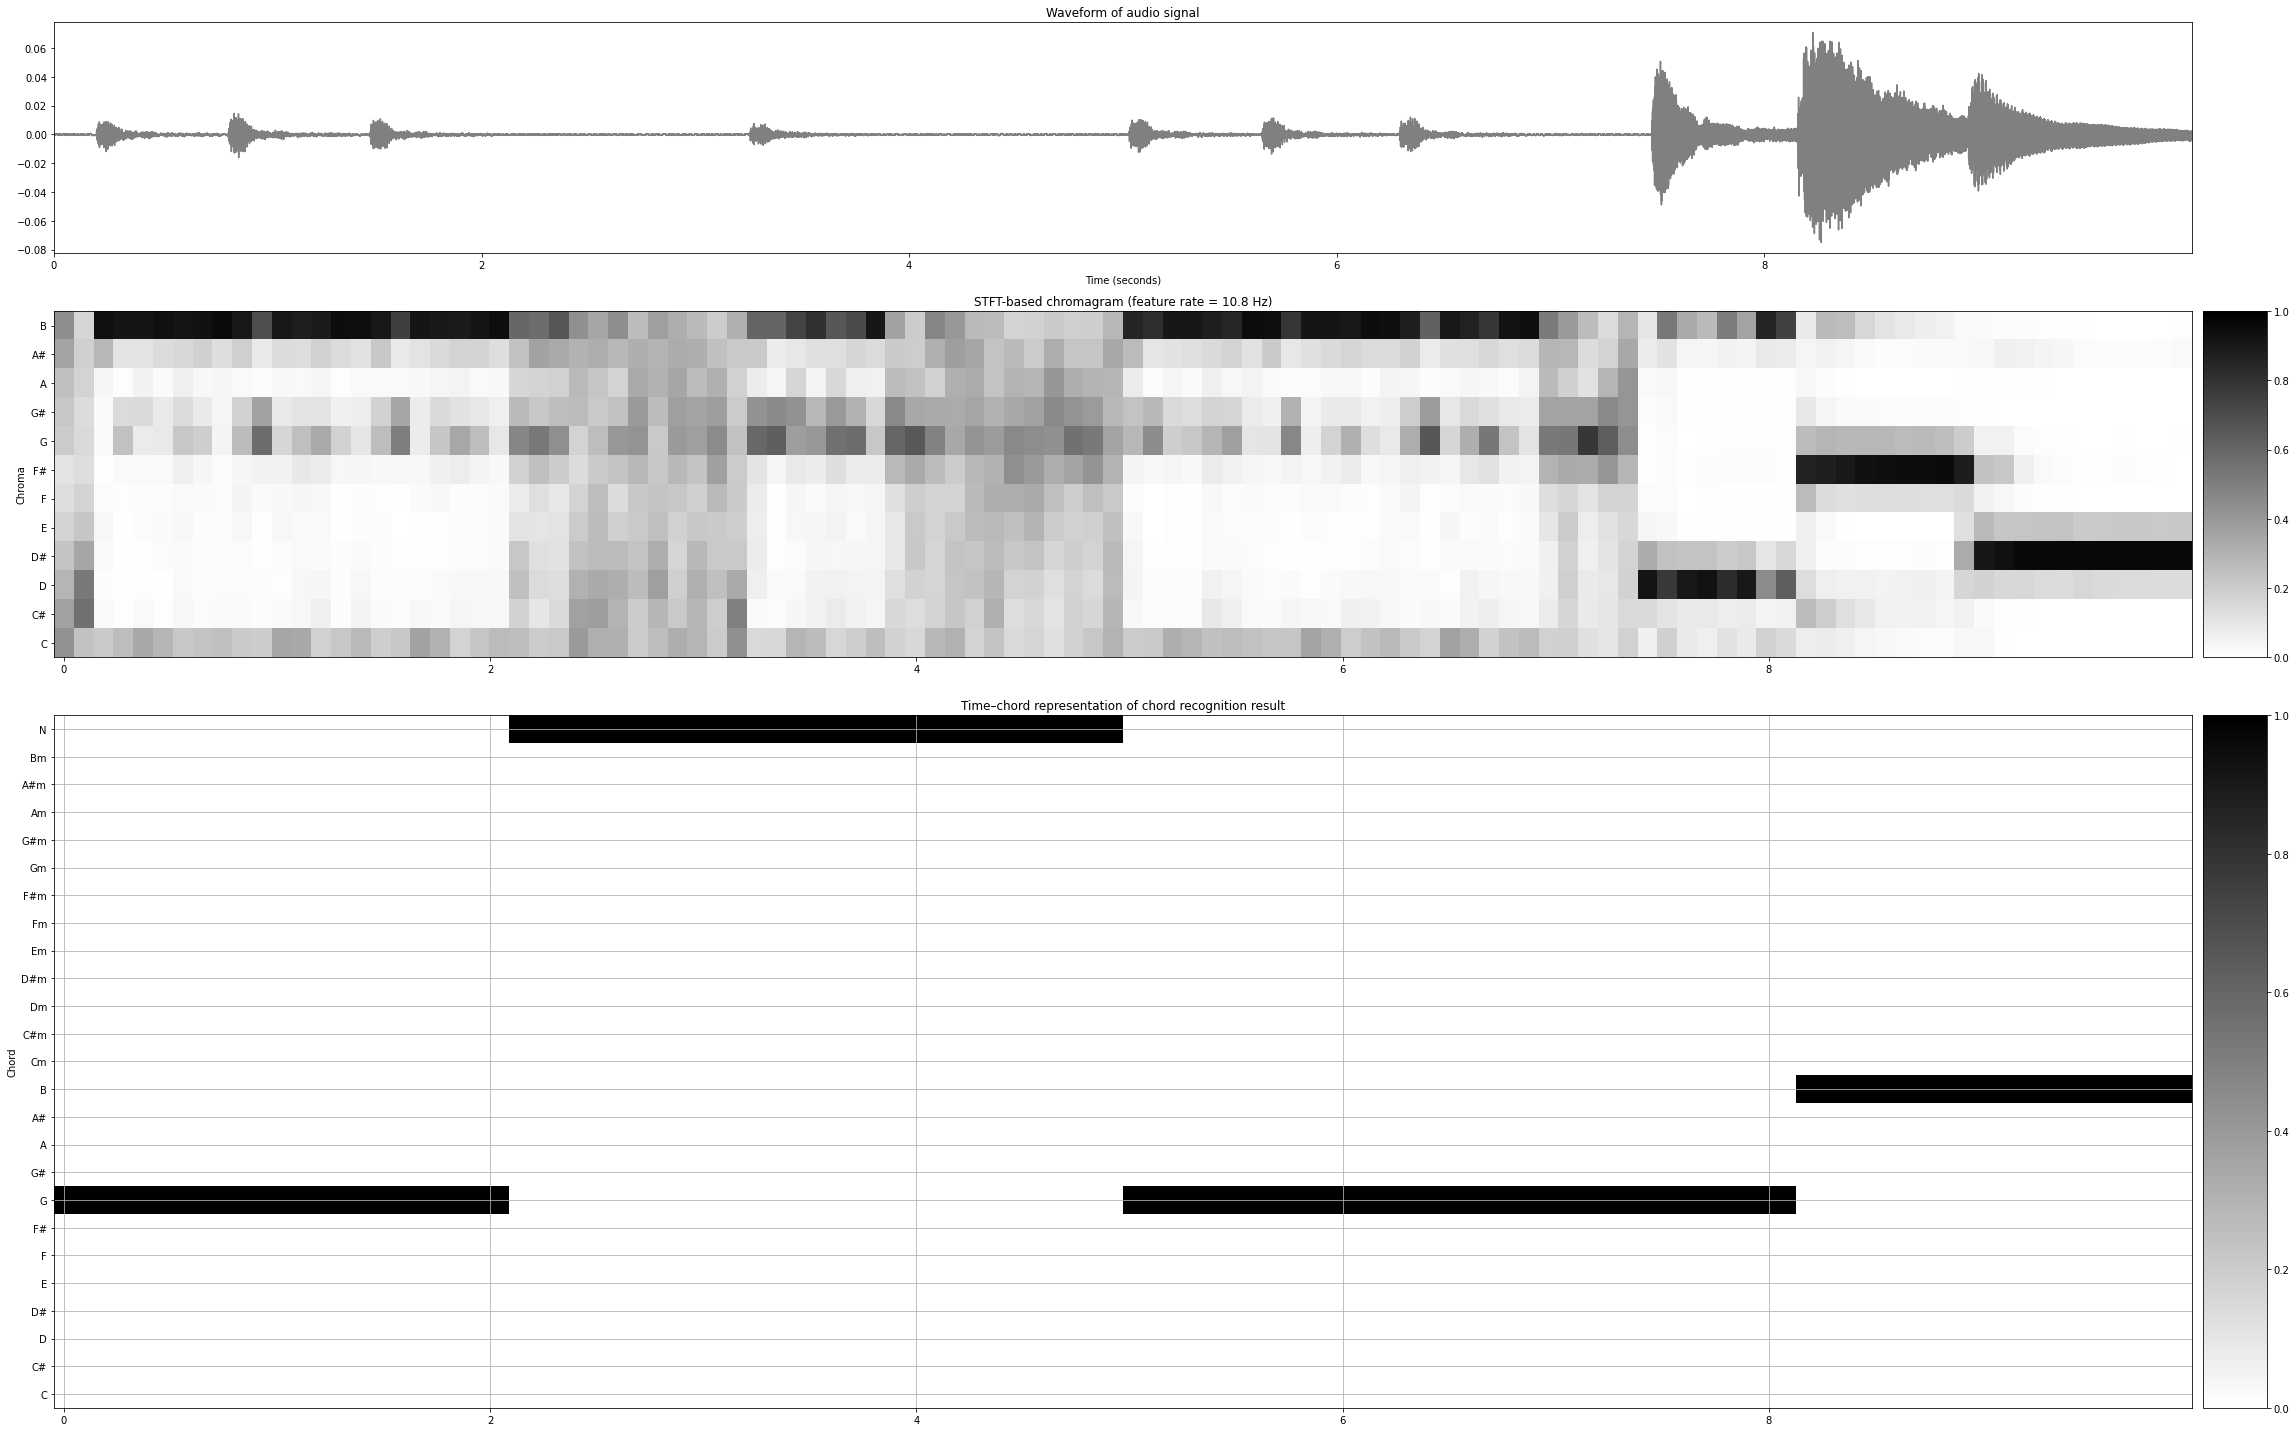

In [13]:
#HMM, NonChord=True
fn_wav =  path + "1-05 6 Kleiner Klavierstücke, Op. 19 - 2. Langsam.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


In [14]:
#HMM, NonChord=False
fn_wav =  path + "1-05 6 Kleiner Klavierstücke, Op. 19 - 2. Langsam.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 24

# Chord recogntion
chord_max_index, get_labels, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


TypeError: ignored

**Strings with voice**
Morgenlied. Steht auf, ihr lieben Kinderlein - Zart bewegt.flac - Webern

In [ ]:
#Template, NonChord=True
fn_wav =  path + "02. Morgenlied. Steht auf, ihr lieben Kinderlein - Zart bewegt.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#Template, NonChord=False
fn_wav =  path + "02. Morgenlied. Steht auf, ihr lieben Kinderlein - Zart bewegt.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#HMM, NonChord=True
fn_wav =  path + "02. Morgenlied. Steht auf, ihr lieben Kinderlein - Zart bewegt.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


In [ ]:
#HMM, NonChord=False
fn_wav =  path + "02. Morgenlied. Steht auf, ihr lieben Kinderlein - Zart bewegt.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 24

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


**Strings only**
27 - Livre pour quatuor, version 1962 - II - Boulez

In [ ]:
#Template, NonChord=True
fn_wav =  path + "27 - Livre pour quatuor, version 1962 - II.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#Template, NonChord=False
fn_wav =  path + "27 - Livre pour quatuor, version 1962 - II.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#HMM, NonChord=True
fn_wav =  path + "27 - Livre pour quatuor, version 1962 - II.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


In [ ]:
#HMM, NonChord=False
fn_wav =  path + "27 - Livre pour quatuor, version 1962 - II.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 24

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


**Orchestra** 
07 Berg – Three Pieces for Orchestra, Op. 6 – 2. Reigen

In [ ]:
#Template, NonChord=True
fn_wav =  path + "07 Berg – Three Pieces for Orchestra, Op. 6 – 2. Reigen.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#Template, NonChord=False
fn_wav =  path + "07 Berg – Three Pieces for Orchestra, Op. 6 – 2. Reigen.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#HMM, NonChord=True
fn_wav =  path + "07 Berg – Three Pieces for Orchestra, Op. 6 – 2. Reigen.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


In [ ]:
#HMM, NonChord=False
fn_wav =  path + "07 Berg – Three Pieces for Orchestra, Op. 6 – 2. Reigen.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 24

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


**Piano with voice**
 Blumengruß. Der Strauß, den ich gepflücket - Webern

In [ ]:
#Template, NonChord=True
fn_wav =  path + "03. Blumengruß. Der Strauß, den ich gepflücket.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#Template, NonChord=False
fn_wav =  path + "03. Blumengruß. Der Strauß, den ich gepflücket.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#HMM, NonChord=True
fn_wav =  path + "03. Blumengruß. Der Strauß, den ich gepflücket.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


In [ ]:
#HMM, NonChord=False
fn_wav =  path + "03. Blumengruß. Der Strauß, den ich gepflücket.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 24

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


**Orchester with voice**
134 - Le Soleil des eaux, 2e version - La Sorgue (Chanson pour Yvonne) - Boulez

In [ ]:
#Template, NonChord=True
fn_wav =  path + "134 - Le Soleil des eaux, 2e version - La Sorgue (Chanson pour Yvonne).flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#Template, NonChord=False
fn_wav =  path + "134 - Le Soleil des eaux, 2e version - La Sorgue (Chanson pour Yvonne).flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#HMM, NonChord=True
fn_wav =  path + "134 - Le Soleil des eaux, 2e version - La Sorgue (Chanson pour Yvonne).flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


In [ ]:
#HMM, NonChord=False
fn_wav =  path + "134 - Le Soleil des eaux, 2e version - La Sorgue (Chanson pour Yvonne).flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 24

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


**Only voice**
02 - Entflieht auf leichten Kaehnen op.2 - Webern

In [ ]:
#Template, NonChord=True
fn_wav =  path + "02 - Entflieht auf leichten Kaehnen op.2.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#Template, NonChord=False
fn_wav =  path + "02 - Entflieht auf leichten Kaehnen op.2.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)


chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

plot_final_atonal(x, Fs, X, chord_max, chords, chord_labels, Fs_X)

In [ ]:
#HMM, NonChord=True
fn_wav =  path + "02 - Entflieht auf leichten Kaehnen op.2.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 25

# Chord recogntion
chord_max_index, chord_max, chord_sim = chord_template(X, norm_sim='max', nonchord=True)
chord_labels = get_labels(nonchord=True)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)


In [ ]:
#HMM, NonChord=False
fn_wav =  path + "02 - Entflieht auf leichten Kaehnen op.2.flac"
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1)
non = 24

# Chord recogntion
chord_max_index, chord_max, chord_sim = (X, norm_sim='max', nonchord=False)
chord_labels = get_labels(nonchord=False)

T = x_dur/len(chord_max_index)
chords = chord_prediction(chord_max_index, chord_labels, T)

A = uniform_transition_matrix(p=0.5, N=non)
C = 1 / non * np.ones((1, non))
B_O = chord_sim
chord_HMM, _, _, _ = viterbi_log_likelihood(A, C, B_O)

plot_final_atonal(x, Fs, X, chord_HMM, chords, chord_labels, Fs_X)
